**Описание работы:**

Перед вами стоит бизнес-задача – на основании имеющихся данных подготовить аналитический отчет, который в дальнейшем поможет продюсерам образовательных программ эффективно выстраивать стратегию по модернизированию и улучшению курсов. В начале отчета предлагается оформить емкий описательный блок по каждому курсу на основании рассчитанных показателей. Далее предлагается посчитать потенциальную нагрузку на преподавателей, чтобы оценить необходимость расширения штата сотрудников. Затем идет блок из двух пунктов по анализу качества контента курсов, где необходимо выявить проблемные модули, которые, возможно, требуют доработки. Также стоит задача выявить потенциальную сезонность. Наконец, предложено задание для самостоятельной разработки метрики успеваемости студентов для нахождения тех, кто значительно хуже справляются с прохождением курса. Каждый из пунктов анализа предполагается сопроводить аналитическим выводом на основании рассчитанных метрик.

In [330]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

pd.reset_option('display.max_rows')

## Codebook

`courses.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор курса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `title` – название курса <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `field` – сфера, к которой относится курс <br> <br><br>
`students.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор студента <br>
&nbsp;&nbsp;&nbsp;&nbsp; `city` – город студента <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `birthday` – день рождения студента <br> <br><br>
`course_contents.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `course_id` – идентификатор курса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `module_number` – номер модуля <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `module_title` – название модуля <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `lesson_number` – номер урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `lesson_title` – название урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `lesson_token` – токен урока <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `is_video` – наличие видео *(true/false)* <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `is_homework` – наличие домашней работы *(true/false)* <br>
<br><br>
`progresses.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `id` – идентификатор прогресса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `student_id` – идентификатор студента <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `course_id` – идентификатор курса <br> <br><br>
`progress_phases.csv` содержит следующие значения: <br><br>
&nbsp;&nbsp;&nbsp;&nbsp; `progress_id` – идентификатор прогресса <br>
&nbsp;&nbsp;&nbsp;&nbsp; `module_number` – номер модуля <br>
&nbsp;&nbsp;&nbsp;&nbsp; `lesson_number` – номер урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `status` – статус прохождения урока <br>
&nbsp;&nbsp;&nbsp;&nbsp;  `start_date` – дата начала <br> 
&nbsp;&nbsp;&nbsp;&nbsp; `finish_date` – дата окончания <br>
<br><br>

## 1. Описание и начальная работа с данными

Вам необходимо подготовить данные и описать их. Данные реальные и содержат пропущенные значения, а также лишние относительно друг друга данные. <br>

Объедините датасеты (кроме `students.scv`) в один общий для дальнейшей работы. Отдельный датасет создайте для расчета среднего возраста студентов курсов (отдельный датасет со `students.scv` нужен, чтобы в основном не потерять значения в основном датасете из-за того, что не по всем студентам есть анкетные данные о дате рождения).

Вам необходимо подготовить данные и описать их. Данные реальные и содержат пропущенные значения, а также лишние относительно друг друга данные.

Объедините датасеты (кроме students.scv) в один общий для дальнейшей работы. Отдельный датасет создайте для расчета среднего возраста студентов курсов (отдельный датасет со students.scv нужен, чтобы в основном не потерять значения в основном датасете из-за того, что не по всем студентам есть анкетные данные о дате рождения).

In [331]:
courses = pd.read_csv('courses.csv', encoding='utf8')
courses.drop(['Unnamed: 0'], axis=1, inplace=True)
courses.columns = ['course_id', 'course_title', 'course_field']
courses.head(1)


,course_id,course_title,course_field
0,943306102e5b067d08a29094f37b8193,Java-разработчик c нуля,Development


In [332]:
course_contents = pd.read_csv('course_contents.csv', encoding='utf8')
course_contents.head(1)


,course_id,module_number,module_title,lesson_number,lesson_title,lesson_token,is_video,is_homework
0,04ba6d0b40670c43a209141fa01fa784,1,"Введение в Motion Design. Тренды, разновидност...",1,Знакомство,aa344de3-1191-4e69-b485-61823118f71c,True,False


In [333]:
progresses = pd.read_csv('progresses.csv', encoding='utf8')
progresses.rename(columns={'id':'progress_id'}, inplace=True)
progresses.head(1)


,progress_id,student_id,course_id
0,8459fbc07e32ec92bd7b43d7df9bfa89,a6ae278c0eab719b3784e5ea147c128f,0770b1b039964228294f1f34b29fc2c1


In [334]:
progress_phases = pd.read_csv('progress_phases.csv', encoding='utf8')
progress_phases.head(1)


,progress_id,module_number,lesson_number,status,start_date,finish_date
0,a387ab916f402cb3fbfffd29f68fd0ce,2,4,done,2018-06-23 08:28:50.681065+00,2018-06-23 08:28:52.439542+00


In [335]:
courses = course_contents.merge(courses, on='course_id')
courses.head(1)


,course_id,module_number,module_title,lesson_number,lesson_title,lesson_token,is_video,is_homework,course_title,course_field
0,04ba6d0b40670c43a209141fa01fa784,1,"Введение в Motion Design. Тренды, разновидност...",1,Знакомство,aa344de3-1191-4e69-b485-61823118f71c,True,False,Анимация интерфейсов,Design


In [336]:
progresses = progress_phases.merge(progresses, on='progress_id')
progresses.head(1)


,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id
0,a387ab916f402cb3fbfffd29f68fd0ce,2,4,done,2018-06-23 08:28:50.681065+00,2018-06-23 08:28:52.439542+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b


In [337]:
df = pd.merge(progresses, courses, on=['course_id', 'module_number', 'lesson_number'],  how='left')
df.head()


,progress_id,module_number,lesson_number,status,start_date,finish_date,student_id,course_id,module_title,lesson_title,lesson_token,is_video,is_homework,course_title,course_field
0,a387ab916f402cb3fbfffd29f68fd0ce,2,4,done,2018-06-23 08:28:50.681065+00,2018-06-23 08:28:52.439542+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Концептуальный дизайн,Практика — мокапы,7df8adef-1259-4b72-9bf2-353c73389d06,True,False,Веб-дизайн PRO 2.0,Design
1,a387ab916f402cb3fbfffd29f68fd0ce,1,1,done,2018-06-20 14:25:21.783762+00,2018-06-20 15:45:07.717209+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Специализация и личное позиционирование,Интро курса,df1a1f20-cdf7-443d-b25b-0a4b990b84d9,True,False,Веб-дизайн PRO 2.0,Design
2,a387ab916f402cb3fbfffd29f68fd0ce,2,2,done,2018-06-23 08:18:09.653771+00,2018-06-23 08:18:12.784616+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Концептуальный дизайн,Что такое концептуальный дизайн,f23b1890-9365-406f-816b-04864cefe58f,True,False,Веб-дизайн PRO 2.0,Design
3,a387ab916f402cb3fbfffd29f68fd0ce,1,4,done,2018-06-20 16:00:06.36178+00,2018-06-21 19:09:30.845034+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Специализация и личное позиционирование,Личное позиционирование,9dd50916-4aa6-4a73-b86c-56a1bd7753c8,True,False,Веб-дизайн PRO 2.0,Design
4,a387ab916f402cb3fbfffd29f68fd0ce,1,6,done,2018-06-21 19:10:36.957891+00,2018-06-28 15:59:25.320418+00,768c2987a744c51ce64a5993a2a94eaf,c9fcb746d51e41bc5a217002d081454b,Специализация и личное позиционирование,Домашняя работа,43e1fbdd-1ee9-4ed5-a577-4dadd80c02b3,False,True,Веб-дизайн PRO 2.0,Design


### 1. Блок расчетов

- Общее количество курсов в датасете

In [338]:
df.course_id.nunique()


15

- Количество модулей на каждом курсе

In [339]:
df.groupby('course_title', as_index=False)[['module_title']].nunique().sort_values(by='course_title') \
.rename(columns={'module_title':'modules_count'})


,course_title,modules_count
0,Excel Базовый,9
1,Java-разработчик,17
2,Java-разработчик c нуля,9
3,JavaScript с нуля,18
4,PHP-разработчик с 0 до PRO. Часть 1,8
5,SMM-маркетолог от А до Я,11
6,UX-дизайн,20
7,Анимация интерфейсов,21
8,Веб-вёрстка для начинающих 2.0,8
9,Веб-дизайн PRO 2.0,17


- Количество уроков в каждом модуле на каждом курсе

In [340]:
df.groupby(['course_title', 'module_title'], as_index=False)[['lesson_title']].nunique() \
  .sort_values(by=['course_title', 'module_title']).rename(columns={'lesson_title':'lessons_count'})


,course_title,module_title,lessons_count
0,Excel Базовый,Визуализация данных Excel,5
1,Excel Базовый,Основной функционал Excel,11
2,Excel Базовый,Основной функционал Excel (продолжение),7
3,Excel Базовый,Сводные таблицы Excel,5
4,Excel Базовый,Формулы и функции Excel. Более сложные формулы,5
...,...,...,...
224,Руководитель digital-проектов,Решение факапов. Lean/TOC. Обзор.,5
225,Руководитель digital-проектов,Требовательность digital-продюсера,4
226,Руководитель digital-проектов,Управление временем,4
227,Руководитель digital-проектов,Управление дизайнерами. Разработка дизайна по ...,7


- Медианное количество уроков в модуле на каждом курсе

In [341]:
df.groupby(['course_title', 'module_title'], as_index=False)[['lesson_title']].nunique() \
  .groupby('course_title', as_index=False)[['lesson_title']].median().rename(columns={'lesson_title':'lessons_medians'})


,course_title,lessons_medians
0,Excel Базовый,5.0
1,Java-разработчик,7.0
2,Java-разработчик c нуля,10.0
3,JavaScript с нуля,7.0
4,PHP-разработчик с 0 до PRO. Часть 1,4.0
5,SMM-маркетолог от А до Я,6.0
6,UX-дизайн,3.5
7,Анимация интерфейсов,3.0
8,Веб-вёрстка для начинающих 2.0,7.0
9,Веб-дизайн PRO 2.0,5.0


- Количество учеников на каждом курсе

In [342]:
df.groupby('course_title')[['student_id']].nunique().rename(columns={'student_id':'students_count'})


,students_count
course_title,
Excel Базовый,782
Java-разработчик,763
Java-разработчик c нуля,581
JavaScript с нуля,966
PHP-разработчик с 0 до PRO. Часть 1,854
SMM-маркетолог от А до Я,506
UX-дизайн,1151
Анимация интерфейсов,598
Веб-вёрстка для начинающих 2.0,2004


- Минимальный, максимальный, средний, медианный возраст студентов

In [343]:
students = pd.read_csv('students.csv', encoding='utf8')
students.drop('id_', axis=1, inplace=True)
students.columns = ['student_id', 'student_city', 'student_birthday']


students['student_birthday'] =  pd.to_datetime(students['student_birthday'], errors='coerce') 
students.dropna(inplace=True)
students['age'] = dt.datetime.now().year - students.student_birthday.dt.year 

students = students.query('(age > 14) & (age < 90)')

students.agg({'age': [np.min, np.max, np.mean, np.median]})


,age
amin,15.000000
amax,86.000000
mean,31.268763
median,31.000000


- Минимальный, максимальный, средний, медианный возраст студентов на каждом курсе

In [344]:
df_ages = df.merge(students, on='student_id')
df_ages.groupby('course_title').agg({'age': [np.min, np.max, np.mean, np.median]})


age                       
                                    amin amax       mean median
course_title                                                   
Excel Базовый                         18   62  34.725516     35
Java-разработчик                      16   66  31.266897     30
Java-разработчик c нуля               16   56  31.039271     30
JavaScript с нуля                     15   61  29.880974     29
PHP-разработчик с 0 до PRO. Часть 1   15   76  32.450883     31
SMM-маркетолог от А до Я              19   53  30.240398     29
UX-дизайн                             16   86  31.893275     31
Анимация интерфейсов                  16   52  31.297778     31
Веб-вёрстка для начинающих 2.0        15   61  30.011794     29
Веб-дизайн PRO 2.0                    16   60  29.994271     29
Веб-дизайн Базовый                    17   52  29.984368     29
Веб-дизайн с нуля 2.0                 16   77  29.798551     29
Веб-разработчик                       15   52  28.956147     28
Интернет-маркетолог от Ingate         18   59  32.973116     32
Руководитель digital-проектов         22   49  33.527342     33

##### 2. Постройте bar-chart, отражающий количество студентов на каждом курсе. Ticks нужно развернуть так, чтобы они были читаемы

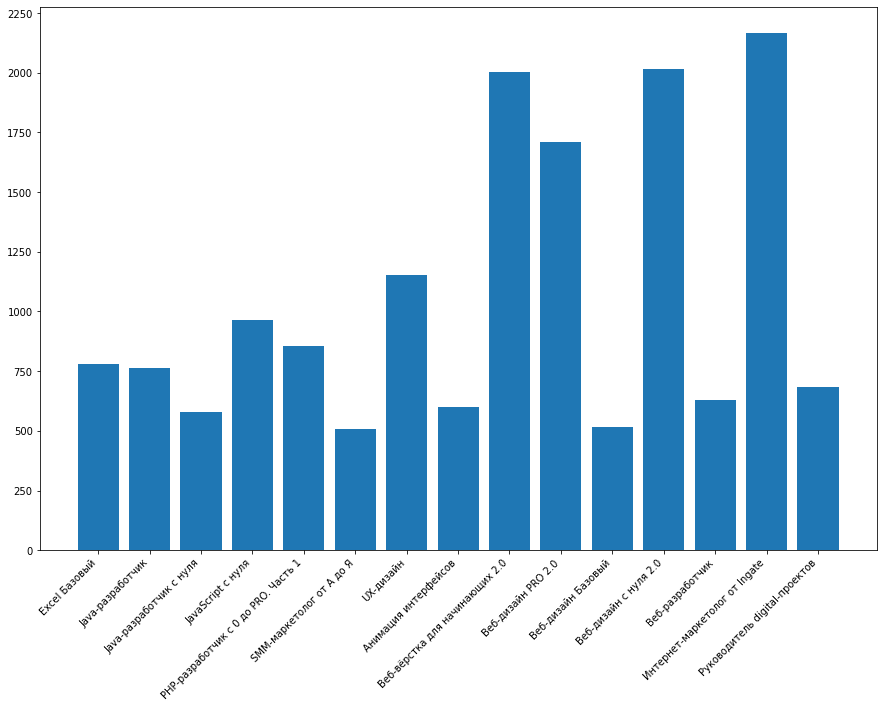

In [345]:
df_course_students = df.groupby('course_title', as_index=False)[['student_id']].nunique() \
                        .rename(columns={'student_id':'students_count'})

plt.figure(figsize=(15, 10))
plt.bar(df_course_students['course_title'], df_course_students['students_count'])
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 2500, 250))
plt.show()


##### 3. Постройте горизонтальный (столбцы должны располагаться горизонтально) bar-chart, отражающий количество студентов на каждом курсе. График должен иметь заголовок. Значения должны быть отсортированы. Цвет столбцов должен содержать информацию о сфере, к которой относится курс (то есть нужна легенда). Прозрачность должна стоять на отметке 0.1. На график должна быть нанесена линия медианы. У медианы должен быть свой цвет. Рамки у графика быть не должно ⭐

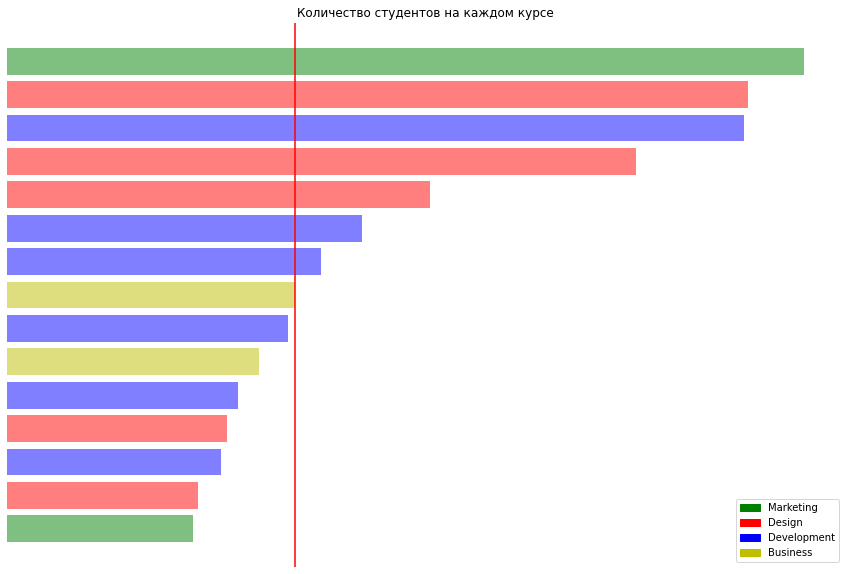

In [346]:
df_course_students_2 = df.groupby(['course_title', 'course_field'], as_index=False)[['student_id']].nunique() \
                        .rename(columns={'student_id':'students_count'}).sort_values(by='students_count')

colors = {'Marketing':'g', 'Design':'r', 'Development':'b', 'Business':'y'}  
c = df_course_students_2['course_field'].apply(lambda x: colors[x])
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]


plt.figure(figsize=(15, 10))
plt.barh(df_course_students_2['course_title'], df_course_students_2['students_count'], alpha=0.5,
         color=c)
plt.axvline(df_course_students_2['students_count'].median(), color = 'r')
plt.title('Количество студентов на каждом курсе')
plt.axis('off')
plt.legend(handles, labels)
plt.show()


##### 4. На основании рассчитанных значений опишите данные (описание должно быть полным и покрывать все полученные выше метрики)

- Проведенный анализ показал, что самыми популярными курсами являются Веб-вёрстка для начинающих 2.0 (2004 студентов), Веб-дизайн с нуля 2.0 (2014 студентов), Интернет-маркетолог от Ingate (2168 студентов), то есть профессии из сферы IT

- Общее количество курсов в датасете -  15

- Количество модулей на курсах от 8 до 21

- Наибольшое число уроков в курсе Java-разработчик c нуля

- Считая, что минимальный возраст студента - 14 лет - на большинстве курсов присутствуют студенты юного возраста

- Максимальный возраст студентов от 47 до 64 лет

- Большинство студентов в возрасте от 27 до 30 лет

## 2. Расчет потенциальной нагрузки на преподавателей

###### 1. Рассчитать прирост студентов на каждом курсе в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно). Считать дату начала прохождения курса студентом по дате начала первой домашней работы.

In [347]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['finish_date'] = pd.to_datetime(df['finish_date'])


In [348]:
df_course_growth = df.query('is_homework == True').groupby(['course_title', 'student_id'], as_index=False) \
.agg({'start_date':'min'})

df_course_growth['start_date_m'] = df_course_growth['start_date'].apply(lambda x:x.strftime('%Y-%m'))

df_course_growth = df_course_growth.groupby(['course_title', 'start_date_m'], as_index=False)[['student_id']].nunique()


In [349]:
sdate = date(2016,3,1)  
edate = date(2019,7,31) 

dates = pd.date_range(sdate,edate,freq='m')
date_month = []

for d in dates:
    date_month.append(str(d)[:7])

for course in df_course_growth.course_title.unique():
    df_temp = df_course_growth[df_course_growth['course_title'] == course]
    for d in date_month:
        if d not in df_temp.start_date_m.unique():
            df_course_growth = df_course_growth.append({'course_title': course, 'start_date_m': d, 'student_id': 0}, ignore_index=True)
            
df_course_growth = df_course_growth.sort_values(by=['course_title', 'start_date_m']) 


##### 2. На основании первого пункта построить line-graph с приростом студентов в каждом месяце для каждого курса. 15 графиков. Графики должны иметь заголовки, оси должны быть подписаны. Ticks нужно развернуть так, чтобы они были читаемы.

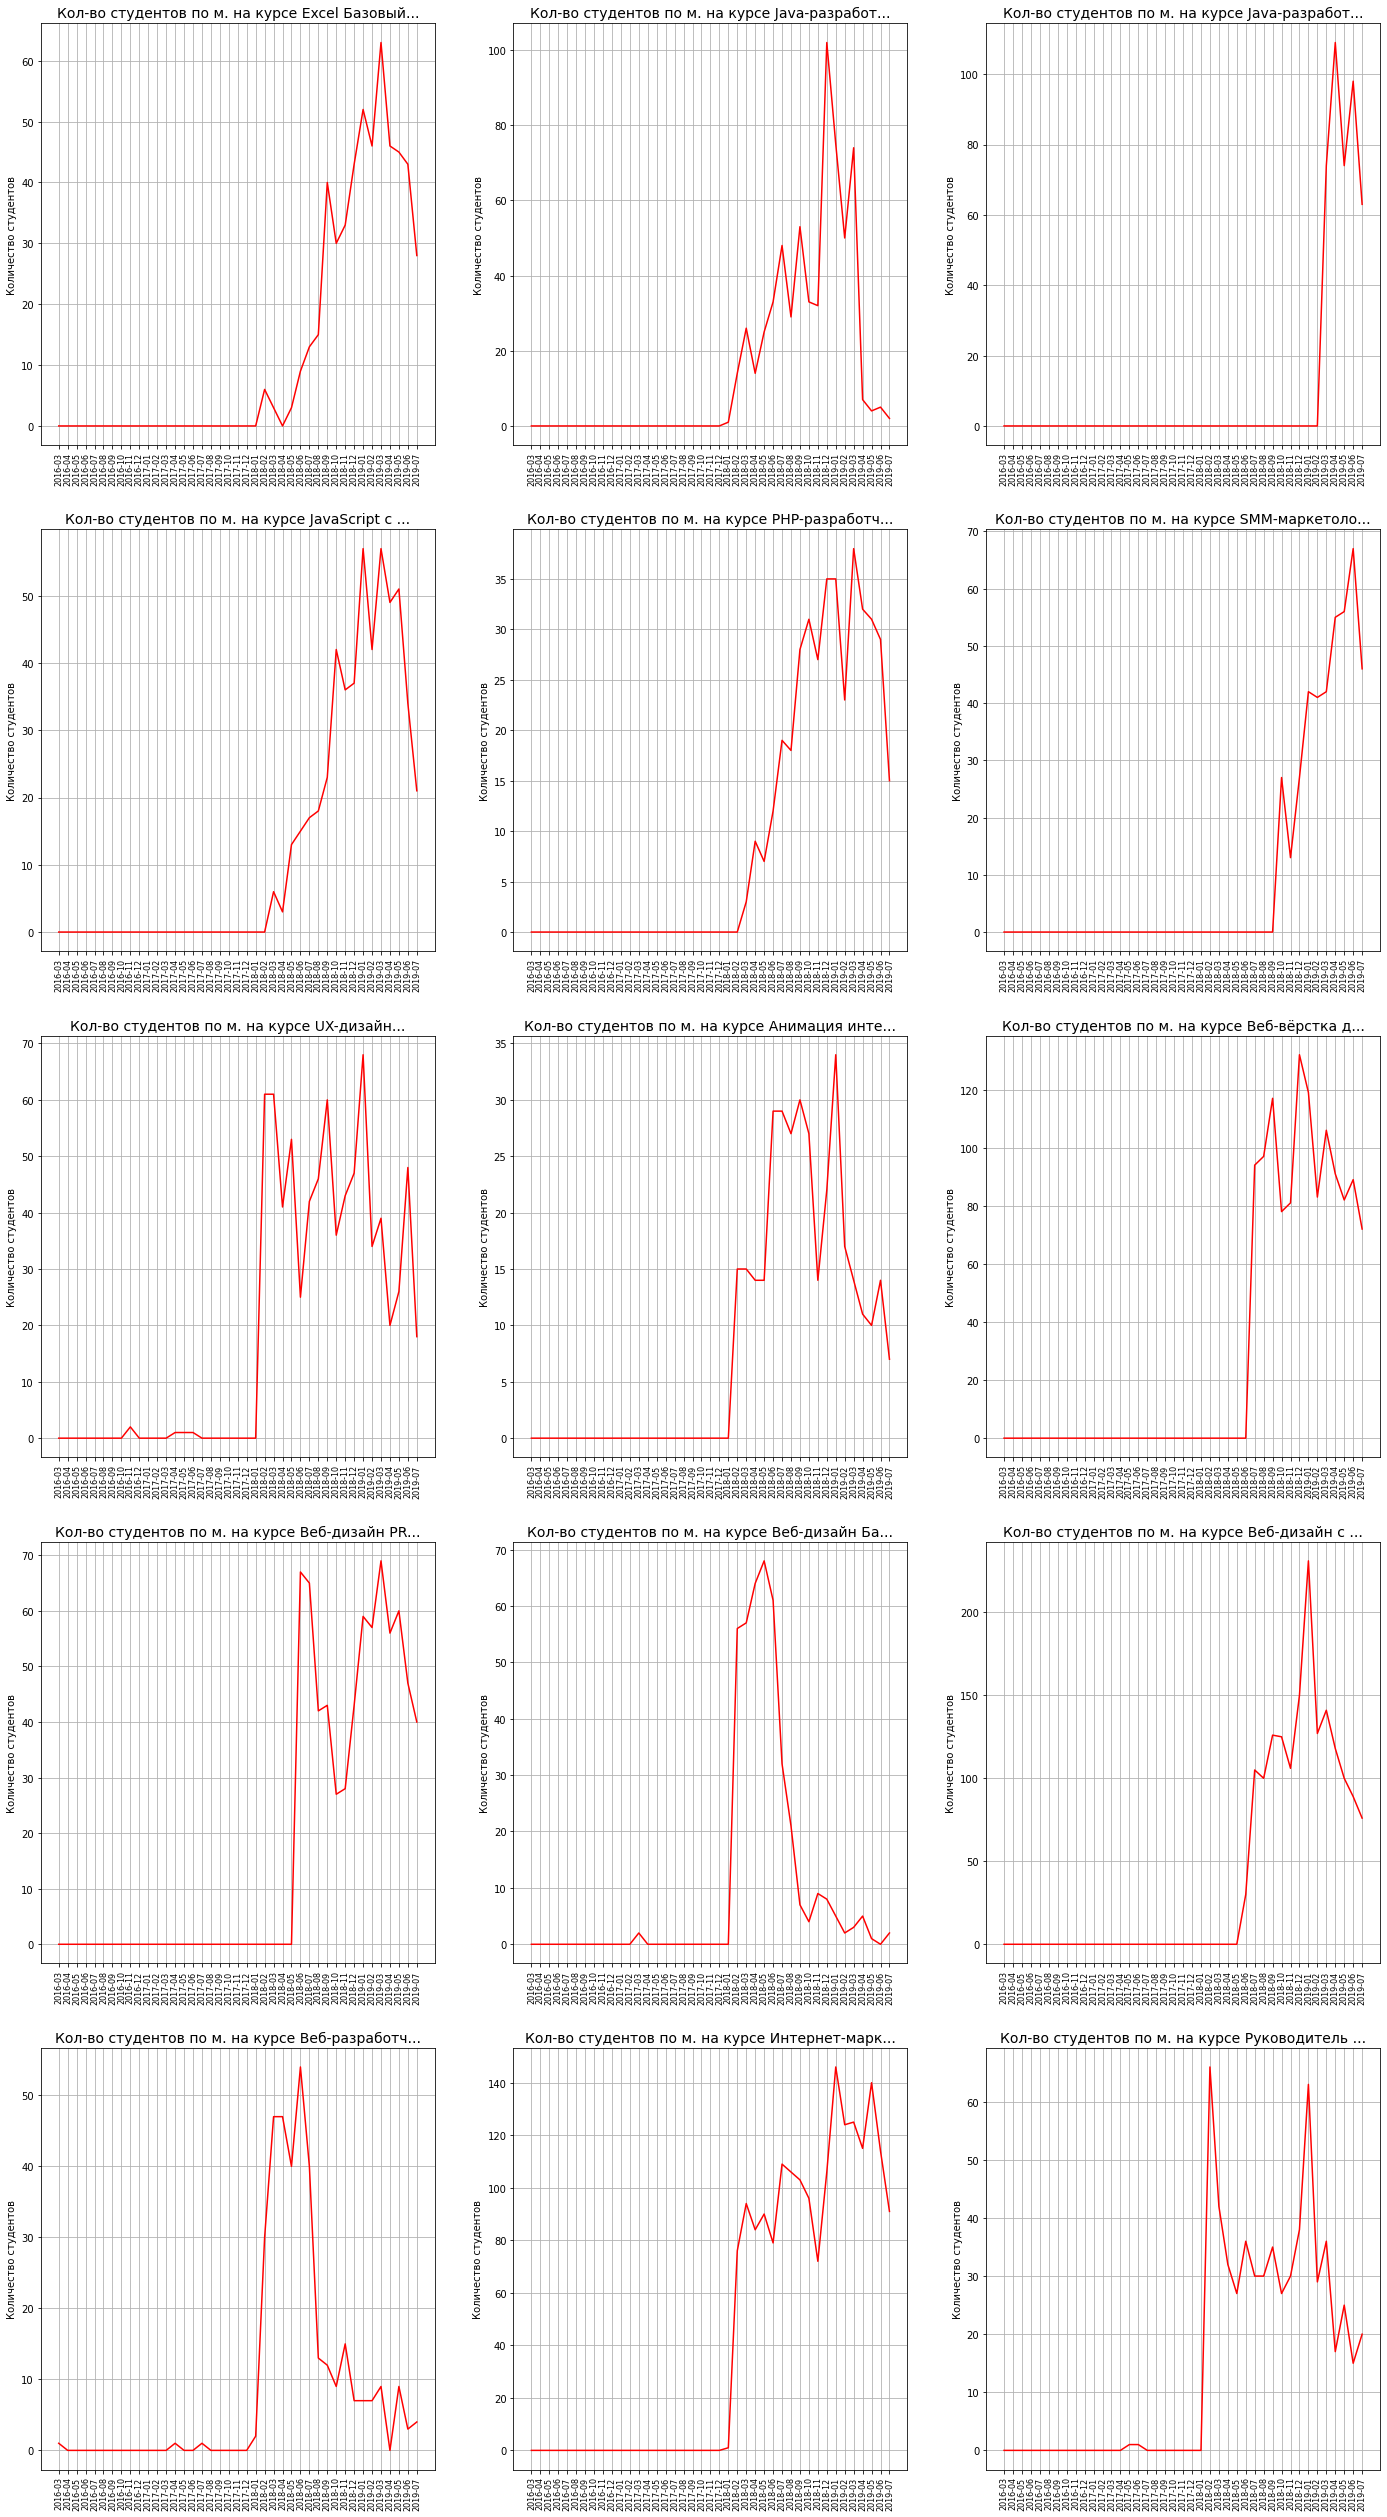

In [350]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='r', linestyle='-') 

plt.figure(figsize=(24, 45))
for i, course in enumerate(df_course_growth.course_title.unique()):
    data = df_course_growth[df_course_growth['course_title'] == course][['start_date_m', 'student_id']]
    plt.subplot(5, 3, i+1)
    plt.plot(data['start_date_m'], data['student_id'])
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', labelsize=8)
    plt.title(str(u'Кол-во студентов по м. на курсе ' + course)[:45] + '...', fontsize=14)
    plt.ylabel(u'Количество студентов')
    plt.grid()
plt.show()


#####  3.На основании первого пункта построить line-graph с несколькими линиями, отражающими прирост студентов в каждом месяце для каждого курса. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая прирост, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐

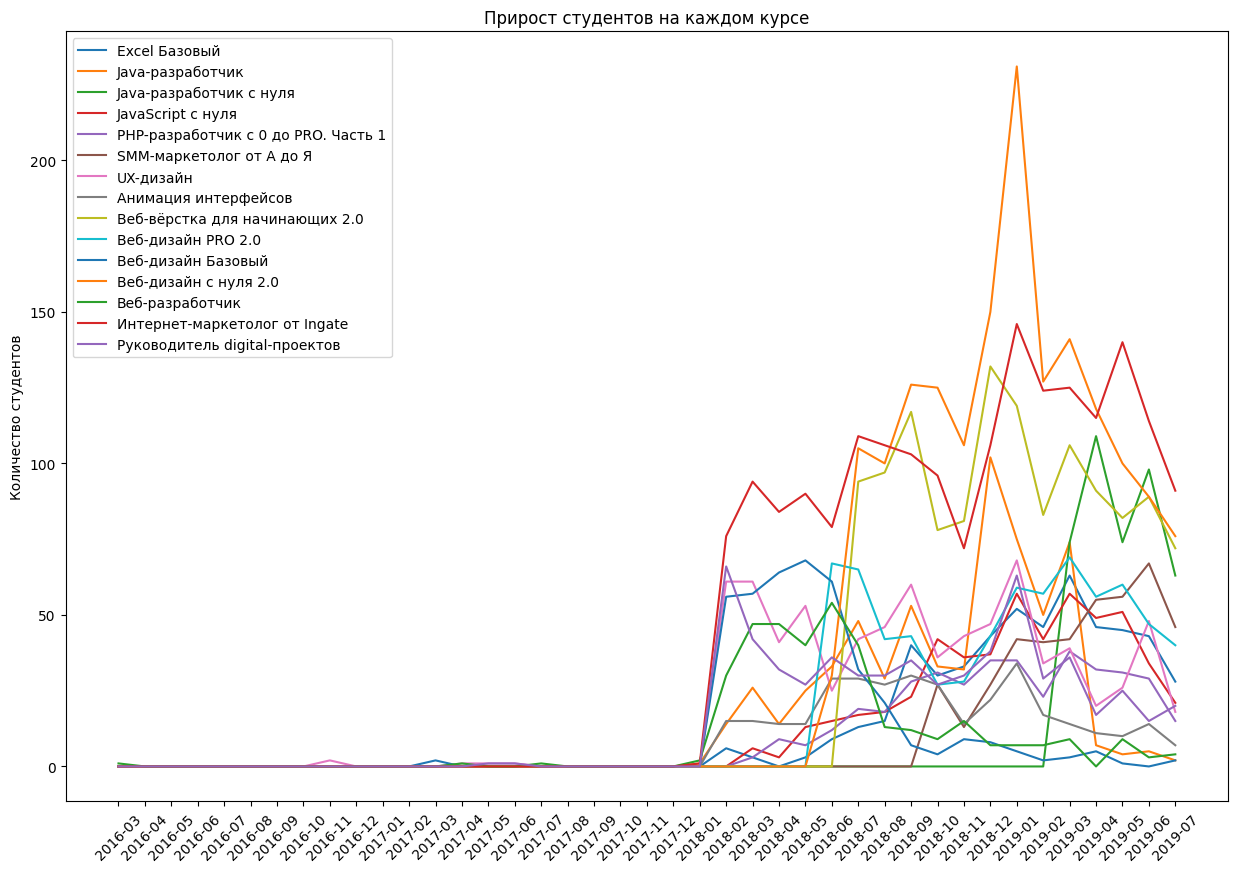

In [351]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(15, 10))

for i, course in enumerate(df_course_growth.course_title.unique()):
    data = df_course_growth[df_course_growth['course_title'] == course][['start_date_m', 'student_id']]
    plt.plot(data['start_date_m'], data['student_id'], label=course)
    
plt.xticks(rotation=45) 
plt.ylabel('Количество студентов')
plt.title('Прирост студентов на каждом курсе')
plt.legend()
plt.show()


Расчет прироста студентов на каждом курсе в каждом месяце за всю историю существования курсов показывает, что максимальный прирост студентов достигается в середине и второй половине периода существования курса, что говорит о том, что курсы дорабатывались в процессе создания и привлекали большее количество студентов, по окончанию доработки прирост студентов в целом стабилизировался.

#####  4. Рассчитать количество прогрессов по выполнению домашних работ в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно) для каждого курса. Учитывать, что выполнение домашнего задания может перетекать из одного месяца в другой (такие дз надо включать в общее число прогрессов для всех месяцев, которые покрывает срок выполнения этих дз)

In [352]:
df_prog = df.copy()


In [353]:
df_prog = df_prog[['progress_id', 'status','is_homework', 'course_title', 'start_date', 'finish_date']]

df_prog = df_prog[(df_prog['is_homework'] == True) & (df_prog['status'] == 'done')]


In [354]:
progress_task = pd.DataFrame({'course_title': [], 'progress_date':[], 'count':[]})

for course in df_prog.course_title.unique():
    for i, row in df_prog.query('course_title == @course').iterrows():
        if row['start_date'].strftime('%Y-%m') == row['finish_date'].strftime('%Y-%m'):
            progress_task = progress_task.append({'course_title': course, 'progress_date': row['start_date'].strftime('%Y-%m'),
                                                  'count': 1}, ignore_index=True)
        else:
             for date in pd.date_range(row['start_date'], row['finish_date'], freq='D').strftime('%Y-%m').unique():
                    progress_task = progress_task.append({'course_title': course, 'progress_date': date, 'count': 1},
                                                         ignore_index=True)
            
    

In [355]:
progress_task_df = progress_task.groupby(['course_title', 'progress_date'], as_index=False)[['count']].sum() \
                                .rename(columns={'count':'progresses'})

for course in progress_task_df.course_title.unique():
    df_temp = progress_task_df[progress_task_df['course_title'] == course]
    for d in date_month:
        if d not in df_temp.progress_date.unique():
            progress_task_df = progress_task_df.append({'course_title': course, 'progress_date': d, 'progresses': 0}, ignore_index=True)

progress_task_df.sort_values(by=['course_title', 'progress_date'], inplace=True)            
            
progress_task_df


,course_title,progress_date,progresses
258,Excel Базовый,2016-03,0.0
259,Excel Базовый,2016-04,0.0
260,Excel Базовый,2016-05,0.0
261,Excel Базовый,2016-06,0.0
262,Excel Базовый,2016-07,0.0
...,...,...,...
253,Руководитель digital-проектов,2019-03,348.0
254,Руководитель digital-проектов,2019-04,261.0
255,Руководитель digital-проектов,2019-05,256.0
256,Руководитель digital-проектов,2019-06,172.0


##### 5. Построить line-graph по четвертому пункту. 15 графиков. Графики должны иметь заголовки, оси должны быть подписаны. Ticks нужно развернуть так, чтобы они были читаемы

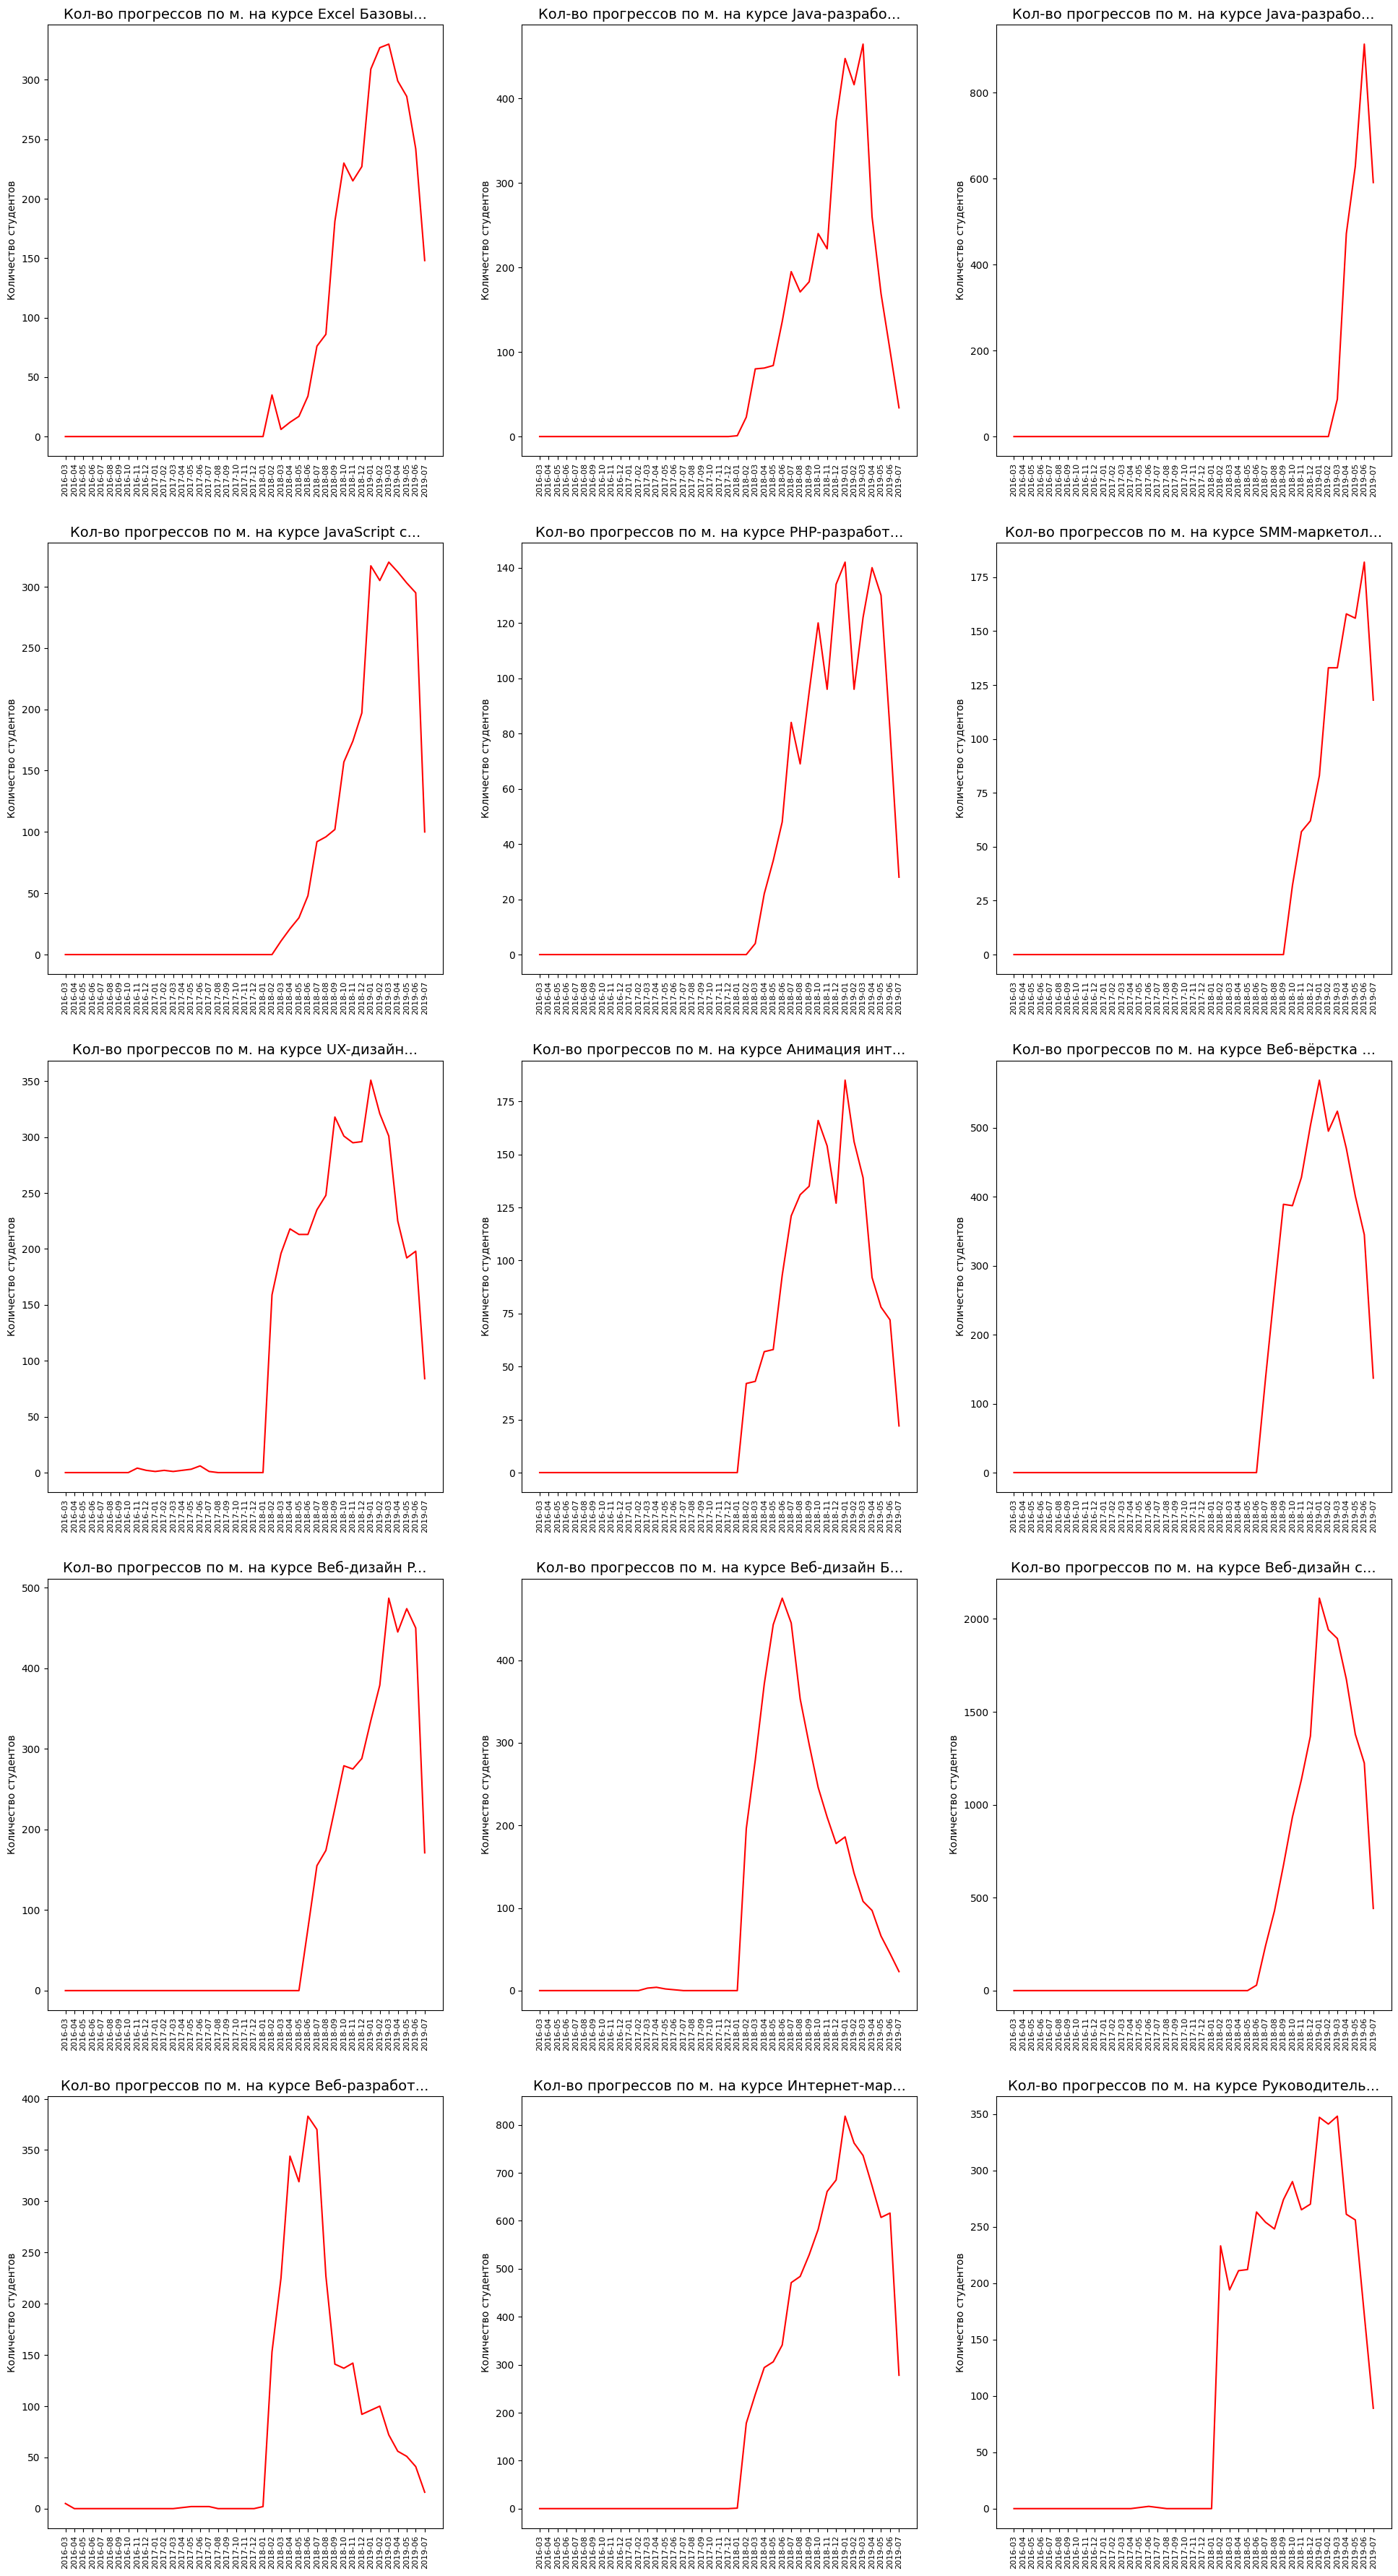

In [356]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='r', linestyle='-') 

plt.figure(figsize=(24, 45))
for i, course in enumerate(df_course_growth.course_title.unique()):
    data = progress_task_df[progress_task_df['course_title'] == course]
    plt.subplot(5, 3, i+1)
    plt.plot(data['progress_date'], data['progresses'])
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', labelsize=8)
    plt.title(str(u'Кол-во прогрессов по м. на курсе ' + course)[:45] + '...', fontsize=14)
    plt.ylabel(u'Количество студентов')
plt.show()


##### 6. Построить один line-graph для всех курсов по четвертому пункту. 15 линий на графике. Ticks нужно развернуть так, чтобы они были читаемы. График должен иметь заголовок. Ось, отражающая количество прогрессов, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно ⭐

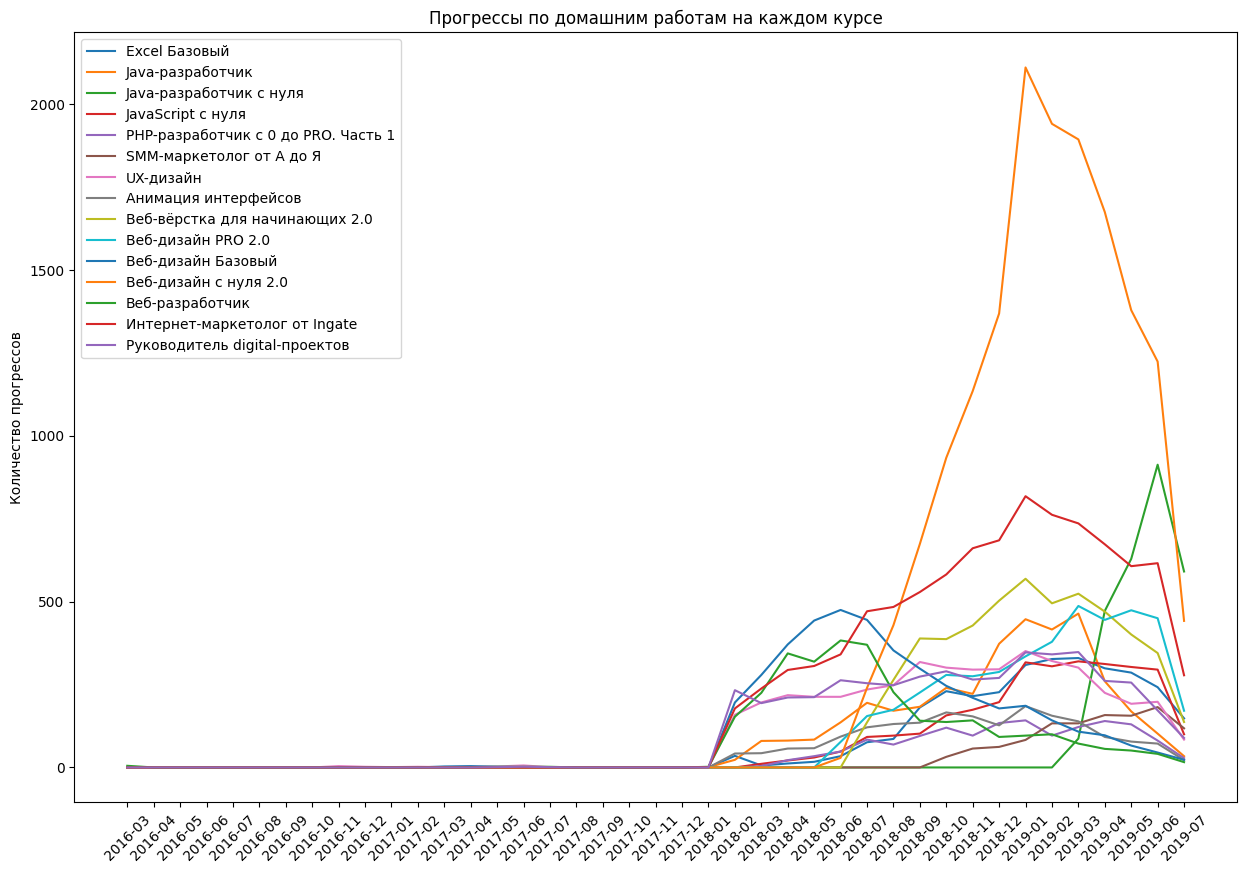

In [357]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(15, 10))

for i, course in enumerate(progress_task_df.course_title.unique()):
    data = progress_task_df[progress_task_df['course_title'] == course]
    plt.plot(data['progress_date'], data['progresses'], label=course)
    
plt.xticks(rotation=45) 
plt.ylabel('Количество прогрессов')
plt.title('Прогрессы по домашним работам на каждом курсе')
plt.legend()
plt.show()


##### 7. На основании рассчитанных значений сделайте аналитический вывод (должен быть полным и покрывать все полученные выше метрики)

Расчет количества прогрессов по выполнению домашних работ в каждом месяце за всю историю (каждый месяц в диапазоне от марта 2016 до июля 2019 включительно) для каждого курса показал, что выполение домашних работ коррелирует с показателем прироста студентов - наибольшее количество домашних работ было выполнено в середине рассматриваемого промежутка существования курса, на данный момент для каждого курса наблюдается уменьшение активности студентов.

## 3. Выявление проблемных модулей

##### 1. Рассчитать минимальное, максимальное, среднее, медианное время прохождения каждого модуля (разность между временем начала и окончания выполнения домашней работы) для каждого курса. Если домашних заданий в модуле несколько, то считать разность между временем начала выполнения первой домашней работы и временем окончания выполнения последней домашней работы в модуле

In [358]:
complete_df = df.groupby(['course_title', 'module_number', 'student_id'], as_index=False) \
                .agg({'start_date':'min', 'finish_date':'max'}).sort_values(by=['course_title', 'module_number'])

complete_df['complete_days'] = (complete_df['finish_date'] - complete_df['start_date']).dt.days

complete_df = complete_df.query('complete_days >= 0')

complete_df.head()


,course_title,module_number,student_id,start_date,finish_date,complete_days
0,Excel Базовый,1,001b192f899a84496be98b41906246fc,2019-01-01 09:39:23.905333+00:00,2019-03-31 07:19:02.064532+00:00,88.0
1,Excel Базовый,1,006f0189ec657741ee4d53474c7a258d,2019-01-18 09:52:22.255231+00:00,2019-01-26 09:52:36.422160+00:00,8.0
2,Excel Базовый,1,0074621b6955733338ab0feb2a9a2100,2019-04-08 10:17:00.167348+00:00,2019-04-13 05:57:59.476184+00:00,4.0
3,Excel Базовый,1,0098ca12f73a56dadbf6099389305d80,2019-03-12 14:15:49.118784+00:00,2019-04-05 09:37:10.695661+00:00,23.0
4,Excel Базовый,1,00b374d9c1cc22543c4d9d3939a6fd8d,2019-01-16 10:54:12.599810+00:00,2019-01-24 10:04:30.250825+00:00,7.0


In [359]:
complete_df_gr = complete_df.groupby(['course_title', 'module_number'])[['complete_days']] \
            .agg([np.min, np.max, np.mean, np.median]).reset_index()

complete_df_gr.columns = ['course_title', 'module_number', 'min_days', 'max_days', 'mean_days', 'median_days']

complete_df_gr


,course_title,module_number,min_days,max_days,mean_days,median_days
0,Excel Базовый,1,0.0,390.0,27.845361,8.0
1,Excel Базовый,2,0.0,274.0,11.884211,4.0
2,Excel Базовый,3,0.0,272.0,8.883212,3.0
3,Excel Базовый,4,0.0,356.0,32.944000,8.0
4,Excel Базовый,5,0.0,294.0,14.752412,5.0
...,...,...,...,...,...,...
224,Руководитель digital-проектов,13,0.0,326.0,33.213483,14.0
225,Руководитель digital-проектов,14,0.0,199.0,21.000000,11.0
226,Руководитель digital-проектов,15,0.0,133.0,12.104478,5.0
227,Руководитель digital-проектов,16,0.0,361.0,20.815385,12.0


##### 2. На основании первого пункта построить line-graph с медианным временем прохождения каждого модуля для каждого курса. 15 графиков. Графики должны иметь заголовки

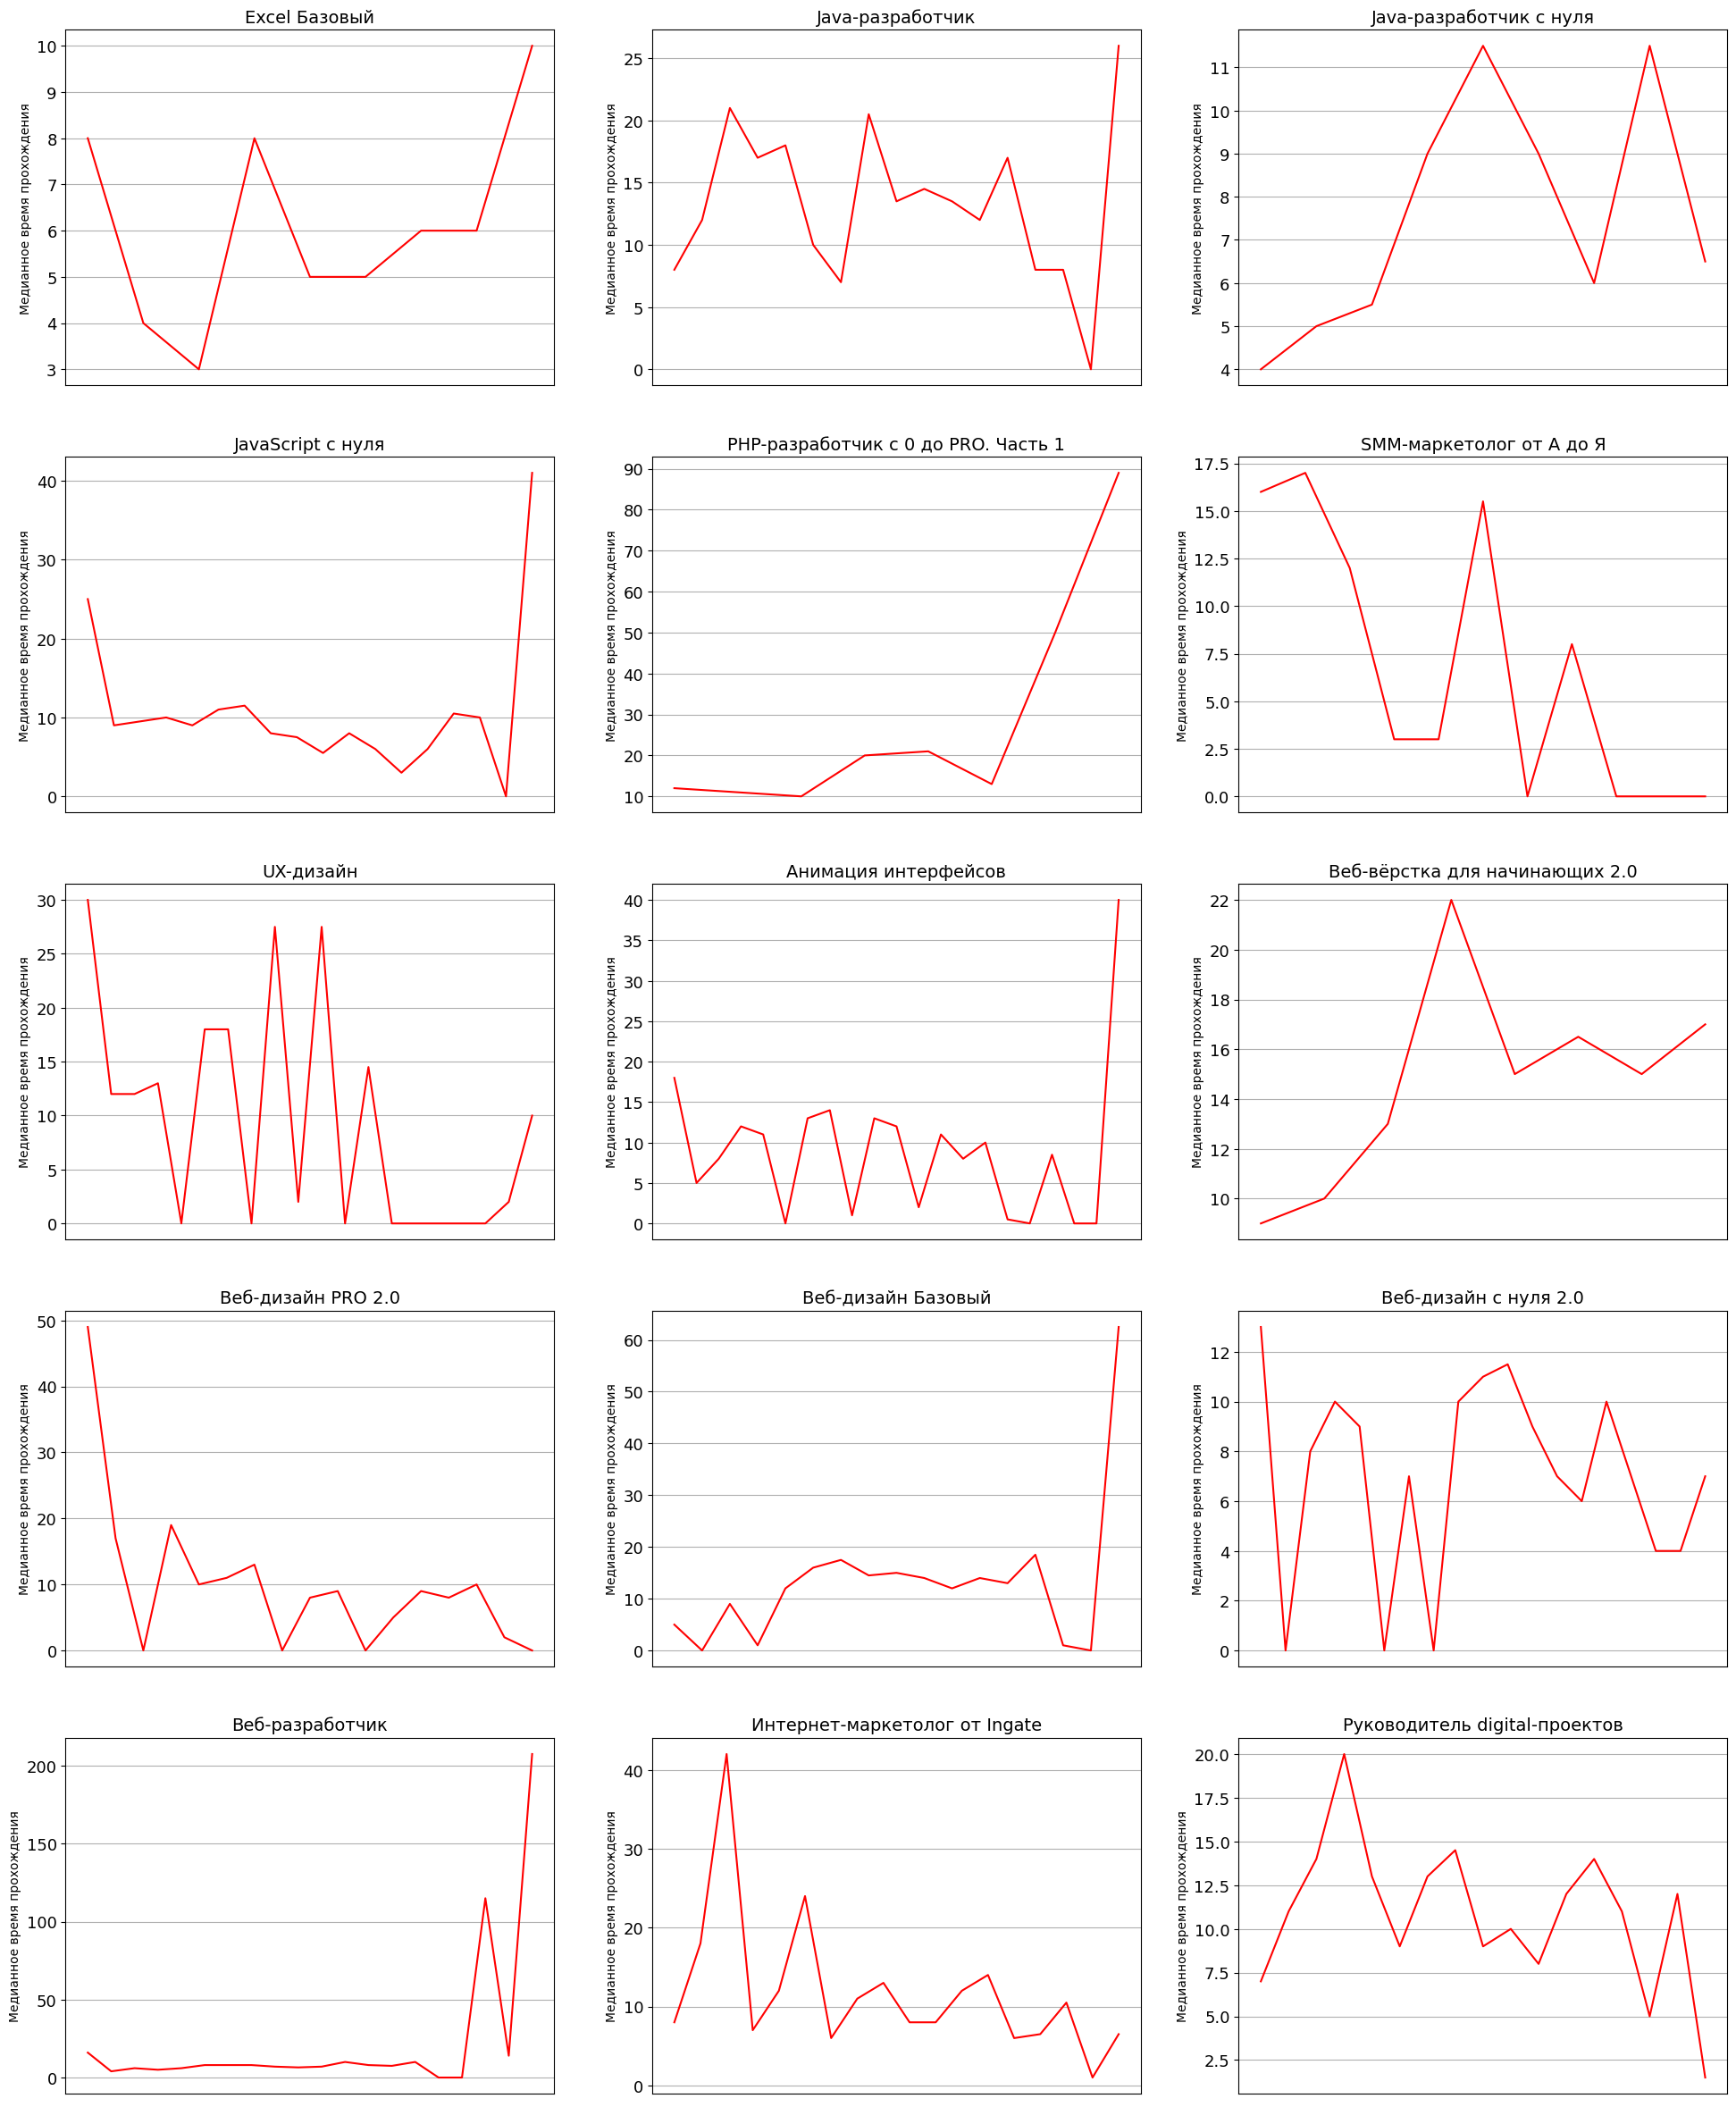

In [360]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color='r', linestyle='-') 

plt.figure(figsize=(24, 30))
for i, course in enumerate(complete_df_gr.course_title.unique()):
    data = complete_df_gr[complete_df_gr['course_title'] == course]
    plt.subplot(5, 3, i+1)
    plt.plot(data['module_number'], data['median_days'])
    plt.xticks([])
    plt.tick_params(axis='y', labelsize=13)
    plt.title(str(course), fontsize=14)
    plt.ylabel(u'Медианное время прохождения')
    plt.grid()
plt.show()


##### 3. Чтобы выявить сезонность, посчитать медианное время выполнения домашней работы по месяцам (12 месяцев, январь-декабрь) для каждого курса. 

In [361]:
complete_df['month_finish'] = complete_df['finish_date'].apply(lambda x:x.month)

complete_monthly = complete_df.groupby(['course_title', 'month_finish'], as_index=False)[['complete_days']].median()

complete_monthly.head()


,course_title,month_finish,complete_days
0,Excel Базовый,1,5.0
1,Excel Базовый,2,7.0
2,Excel Базовый,3,6.0
3,Excel Базовый,4,6.0
4,Excel Базовый,5,6.0


##### 4. На основании третьего пункта построить line-graph, на который будут нанесены линии для каждого курса с медианным временем выполнения домашней работы по месяцам. 15 линий на графике. График должен иметь заголовок. Ось, отражающая время прохождения, должна быть подписана. Линия для каждого курса должна иметь свой цвет (нужна легенда). Рамок у графика быть не должно  ⭐

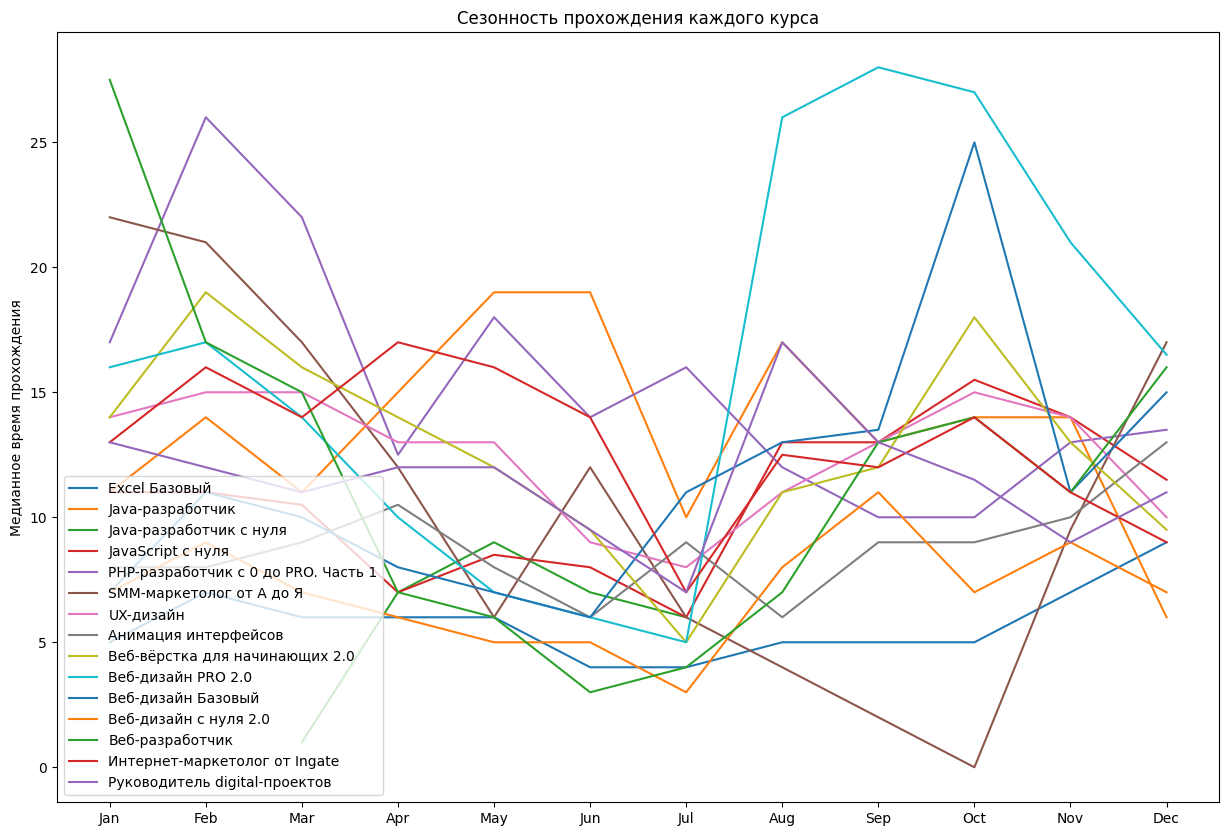

In [362]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(15, 10))

for i, course in enumerate(complete_monthly.course_title.unique()):
    data = complete_monthly[complete_monthly['course_title'] == course]
    plt.plot(data['month_finish'], data['complete_days'], label=course)
    
plt.xticks(ticks=np.arange(1, 13), 
           labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]) 
plt.ylabel('Медианное время прохождения')
plt.title('Сезонность прохождения каждого курса')
plt.legend(loc='lower left')
plt.show()



##### 5. На основании рассчитанных значений сделайте аналитический вывод (должен быть полным и покрывать все полученные выше метрики)

- Медианное время прохождения каждого модуля (разность между временем начала и окончания выполнения домашней работы) для каждого курса в среднем занимает порядка 5-15 дней.

- Значительное время у студентов занимает экзаменационная работа в конце каждого курса

- Наибольшое время прохождение у студентов занимается экзаменационная работа на курсе "Веб-разработчик"

- Расчитанное медианное время выполнения домашней работы по месяцам (12 месяцев, январь-декабрь) для каждого курса показывает, что наибольшую активность студенты проявляют в период осень-зима (начало сентября - конец декабря)

## 4. Расчет конверсии

##### 1. Посчитать конверсию перехода студентов из одного модуля в другой на каждом курсе. Формула: отношение количества студентов, приступивших к выполнению домашнего задания в этом модуле (если дз в модуле несколько, то считать по первому дз в модуле), к количеству студентов, сдавших задание в предыдущем модуле (если дз в модуле несколько, то считать по последнему дз в модуле).

In [363]:
df.start_date.isna().sum()


0

In [364]:
modules_start = df[df['is_homework'] == True].groupby(['course_title', 'module_title', 'module_number'], as_index=False)[['student_id']] \
.nunique().sort_values(by=['course_title', 'module_number']).rename(columns={'student_id':'students_start'})

modules_start.head()


,course_title,module_title,module_number,students_start
1,Excel Базовый,Основной функционал Excel,1,518
2,Excel Базовый,Основной функционал Excel (продолжение),2,434
5,Excel Базовый,Формулы и функции Excel. Введение,3,398
6,Excel Базовый,Формулы и функции Excel. Продолжаем работать с...,4,345
4,Excel Базовый,Формулы и функции Excel. Более сложные формулы,5,298


In [365]:
modules_finish = df[(df['status'] == 'done') & (df['is_homework'] == True)].groupby(['course_title', 'module_title', 'module_number', 'student_id'], 
                as_index=False)[['finish_date']].max().groupby(['course_title', 'module_title', 'module_number'], as_index=False) \
                .agg({'student_id': 'nunique'}).rename(columns={'student_id': 'finishers'})

modules_finish.head()


,course_title,module_title,module_number,finishers
0,Excel Базовый,Визуализация данных Excel,7,200
1,Excel Базовый,Основной функционал Excel,1,458
2,Excel Базовый,Основной функционал Excel (продолжение),2,406
3,Excel Базовый,Сводные таблицы Excel,8,186
4,Excel Базовый,Формулы и функции Excel. Более сложные формулы,5,270


In [366]:
conversion_df = modules_start.merge(modules_finish, on=['course_title', 'module_title', 'module_number'])

conversion_df['finishers_prev'] = conversion_df['finishers'].transform(lambda x:x.shift())

conversion_df['conversion'] = np.round(conversion_df['students_start'] / conversion_df['finishers_prev'], 3)

conversion_df = conversion_df.query('conversion != 1 & module_number != 1').dropna()

conversion_df.head()


,course_title,module_title,module_number,students_start,finishers,finishers_prev,conversion
1,Excel Базовый,Основной функционал Excel (продолжение),2,434,406,458.0,0.948
2,Excel Базовый,Формулы и функции Excel. Введение,3,398,387,406.0,0.980
3,Excel Базовый,Формулы и функции Excel. Продолжаем работать с...,4,345,303,387.0,0.891
4,Excel Базовый,Формулы и функции Excel. Более сложные формулы,5,298,270,303.0,0.983
5,Excel Базовый,"Формулы и функции Excel. Работа с ошибками, пр...",6,263,242,270.0,0.974


##### 2. Постройте bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе. График должен иметь заголовок. Ticks нужно развернуть так, чтобы они были читаемы

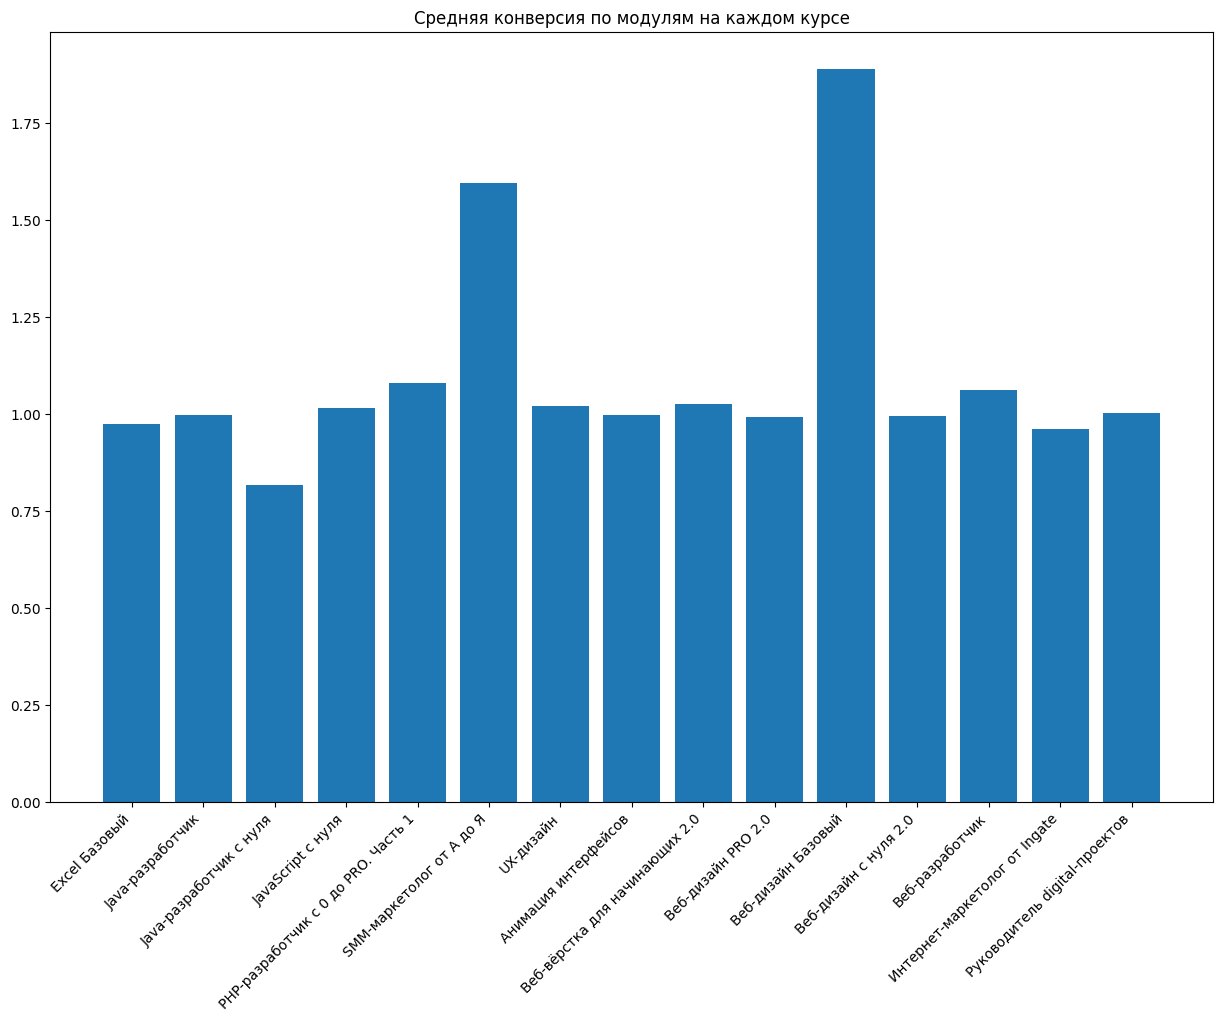

In [367]:
bar_conversion = conversion_df.groupby('course_title', as_index=False)[['conversion']].mean()

plt.figure(figsize=(15, 10))
plt.bar(bar_conversion['course_title'], bar_conversion['conversion'])
plt.xticks(rotation=45, ha='right')
plt.title('Средняя конверсия по модулям на каждом курсе')
plt.show()


##### 3. Постройте горизонтальный (столбцы должны располагаться горизонтально) bar-chart, отражающий конверсию перехода студентов из одного модуля в другой на каждом курсе. 15 графиков. Графики должны иметь заголовки. Ticks должны содержать номер и название модуля. Цвет столбцов графиков должен содержать информацию о сфере, к которой относится курс (нужна легенда). Прозрачность должна стоять на отметке 0.1. На графики должна быть нанесена линия медианы конверсии для каждого курса. У медианы должен быть свой цвет. Рамок у графиков быть не должно ⭐

In [368]:
conversion_df['module'] = conversion_df['module_number'].astype('str') + '. ' + conversion_df['module_title'].astype('str')

fields = courses[['course_title', 'course_field']].drop_duplicates()

conversion_df = conversion_df.merge(fields, on='course_title')

conversion_df.head()


,course_title,module_title,module_number,students_start,finishers,finishers_prev,conversion,module,course_field
0,Excel Базовый,Основной функционал Excel (продолжение),2,434,406,458.0,0.948,2. Основной функционал Excel (продолжение),Business
1,Excel Базовый,Формулы и функции Excel. Введение,3,398,387,406.0,0.980,3. Формулы и функции Excel. Введение,Business
2,Excel Базовый,Формулы и функции Excel. Продолжаем работать с...,4,345,303,387.0,0.891,4. Формулы и функции Excel. Продолжаем работат...,Business
3,Excel Базовый,Формулы и функции Excel. Более сложные формулы,5,298,270,303.0,0.983,5. Формулы и функции Excel. Более сложные формулы,Business
4,Excel Базовый,"Формулы и функции Excel. Работа с ошибками, пр...",6,263,242,270.0,0.974,"6. Формулы и функции Excel. Работа с ошибками,...",Business


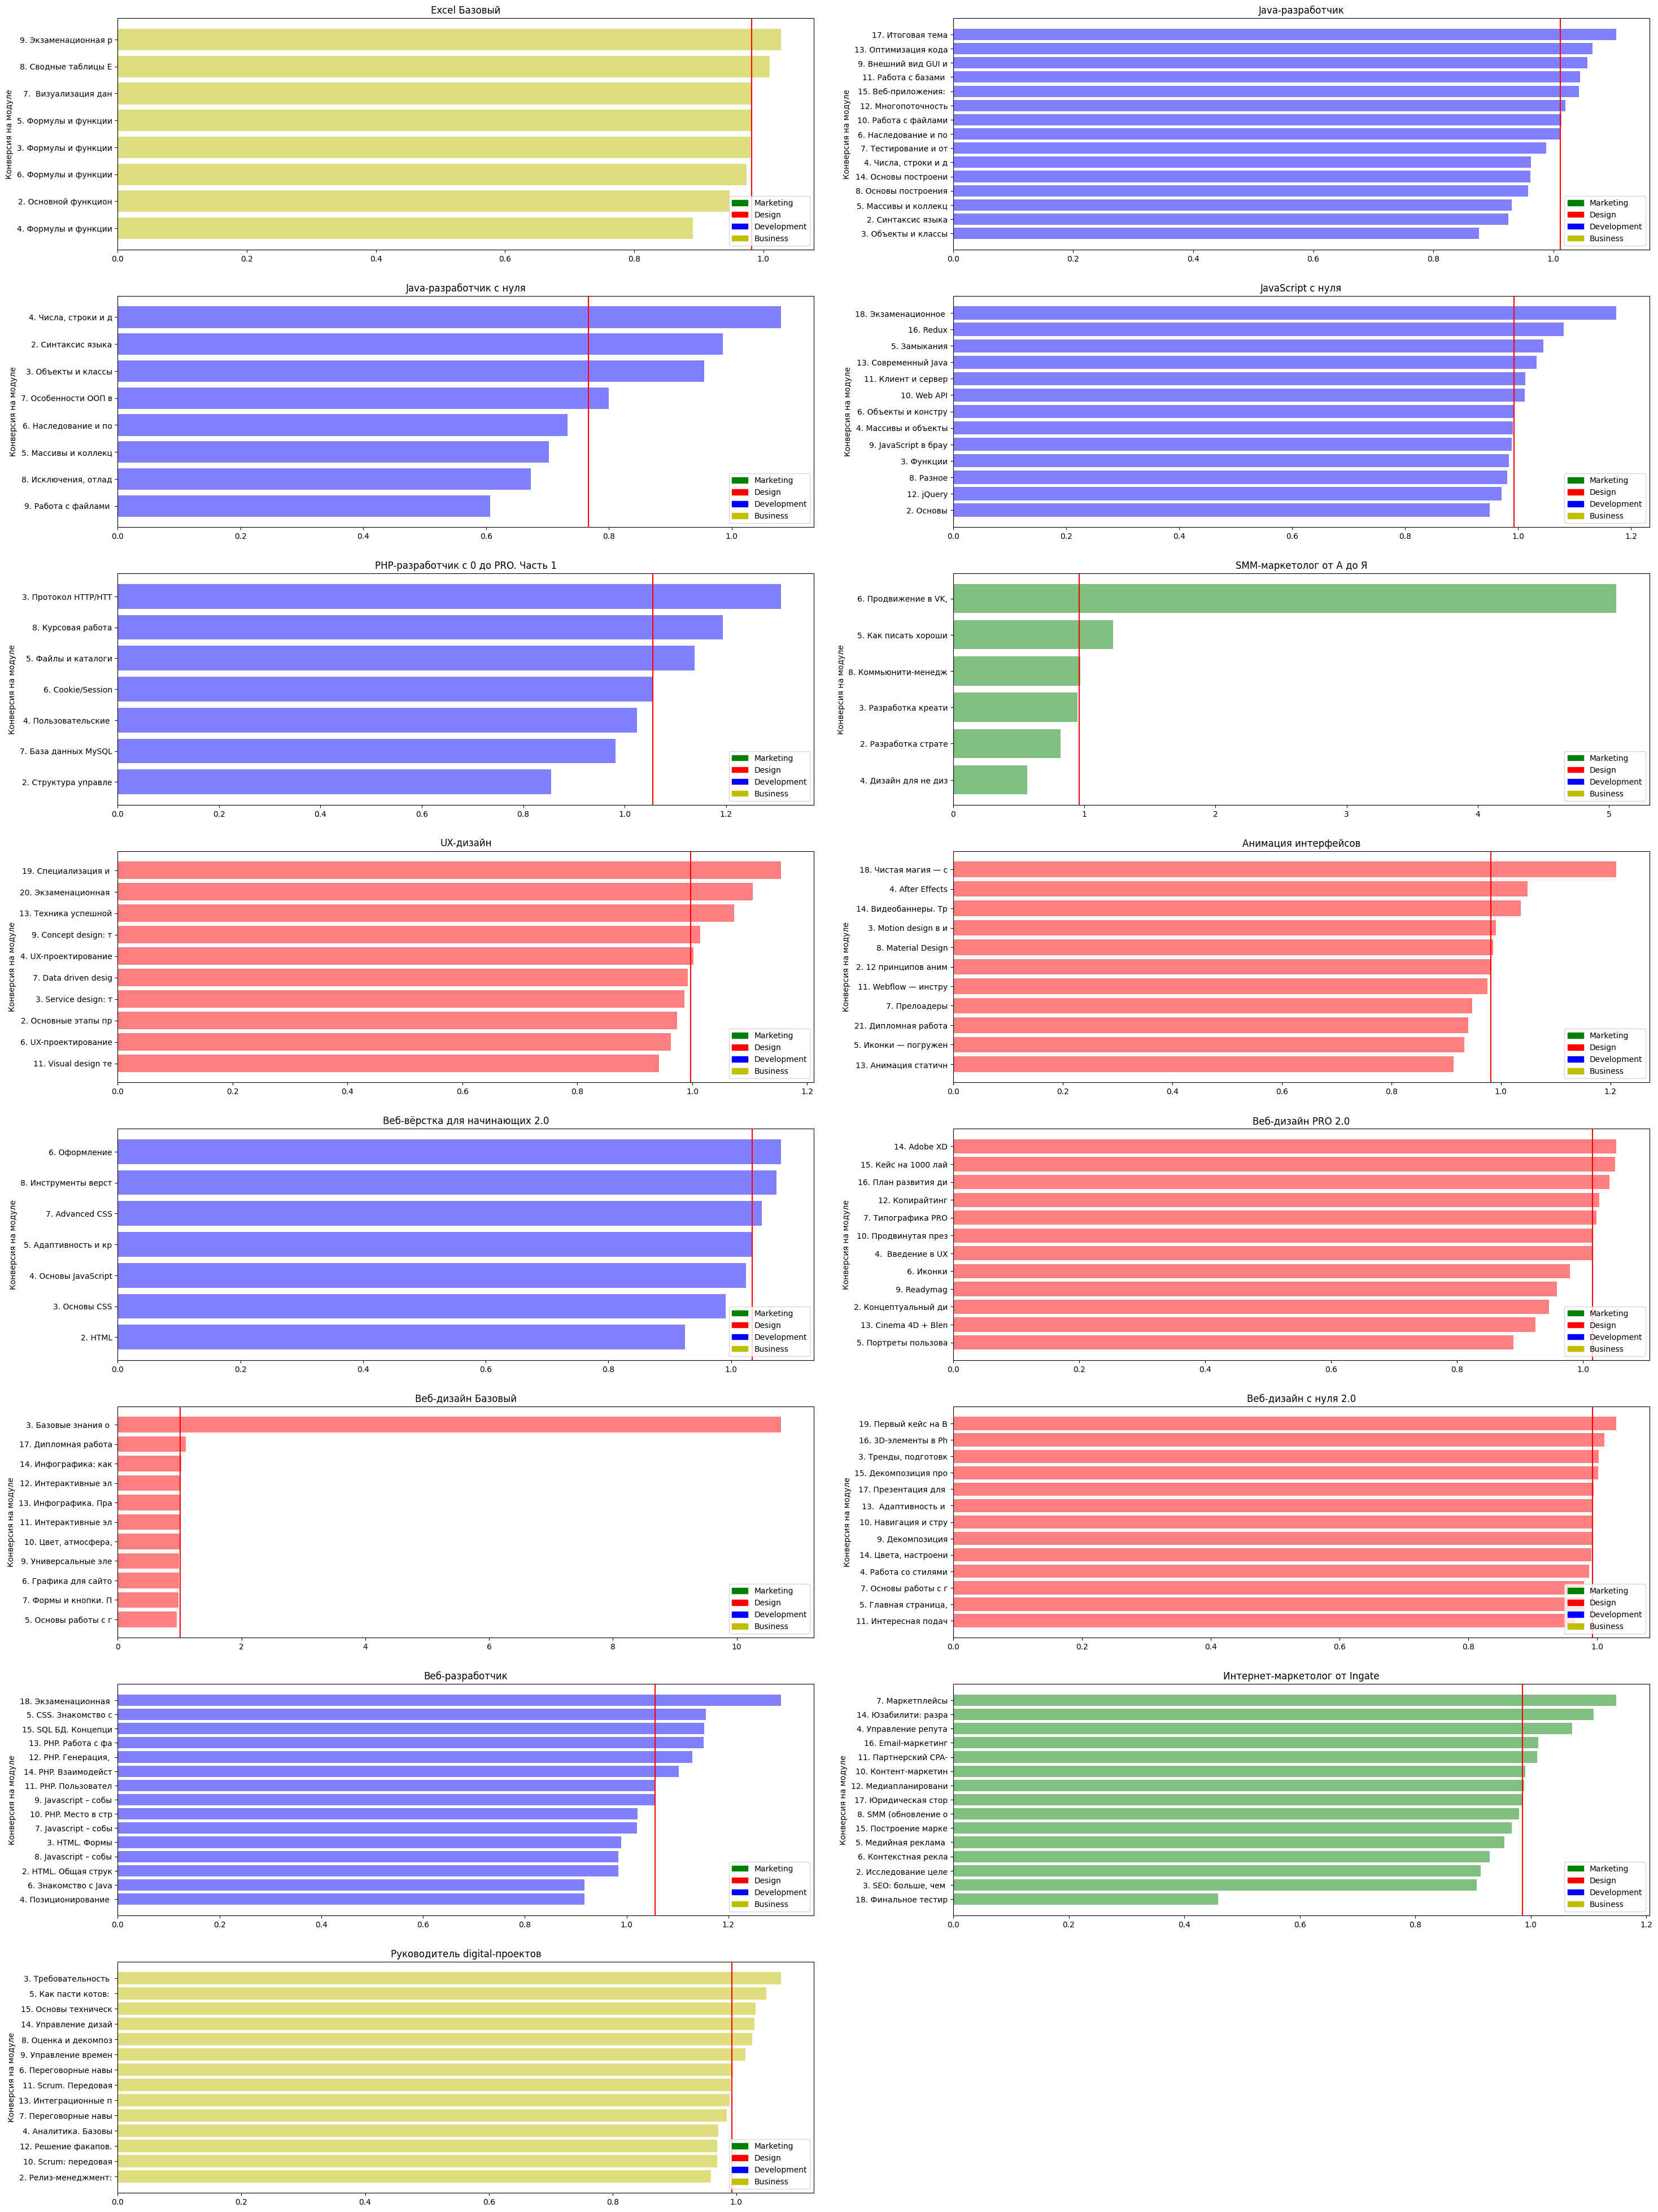

In [369]:
colors = {'Marketing':'g', 'Design':'r', 'Development':'b', 'Business':'y'}  
conversion_df['c'] = conversion_df['course_field'].apply(lambda x: colors[x])
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

plt.figure(figsize=(35, 50))
for i, course in enumerate(conversion_df.course_title.unique()):
    plt.subplot(8, 2, i+1)
    temp_df = conversion_df[conversion_df['course_title'] == course].sort_values(by='conversion')
    temp_df['module'] = temp_df['module'].apply(lambda x:x[:20])

    plt.barh(temp_df['module'], temp_df['conversion'], alpha=0.5,
             color=temp_df['c'].unique()[0])
    plt.axvline(temp_df['conversion'].median(), color='r')
    plt.ylabel('Конверсия на модуле')
    plt.title(course)
    plt.legend(handles, labels, loc='lower right')
    
plt.show()


##### 4. На основании рассчитанных значений сделайте аналитический вывод (должен быть полным и покрывать все полученные выше метрики)

Наибольшая средняя конверсия у курсов 'Веб-дизайн Базовый' и 'SMM-маркетолог от А до Я'.

Конверсия перехода студентов из одного модуля в другой на каждом курсе равна примерна единице, что говорит о вовлеченности студентов в обучение и тот факт, что большинство студентов справляются с заданием и выполняют его последовательно.

За исключением курсов 'Веб-дизайн Базовый' и 'SMM-маркетолог от А до Я' Студенты не завершают предыдущий модуль и переходят к изучению следующего модуля.